# Deep Learning Project: Pet Classifier using CNN

### Import modules

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import os
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random
import sys

# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

### Set hyper parameters
- Run the program with three num_steps : 100,200,300

In [2]:
reset_graph()

img_size = 32
num_channels = 3
img_size_flat = img_size * img_size * num_channels
img_shape = (img_size, img_size)
trainpath='./data/train'
testpath='./data/test'
labels = {'cats': 0, 'dogs': 1}
fc_size=32 #size of the output of final FC layer
num_steps=300 #Try 100, 200, 300. number of steps that training data should be looped. Usually 20K
tf.logging.set_verbosity(tf.logging.INFO)

### Read the image dataset

length of train image set 40
X_data shape: (40, 32, 32, 3)
y_data shape: (40,)


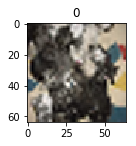

In [3]:
def read_images_classes(basepath,imgSize=img_size):
    image_stack = []
    label_stack = []

    for counter, l in enumerate(labels):
        path = os.path.join(basepath, l,'*g')
        for img in glob.glob(path):
            one_hot_vector =np.zeros(len(labels),dtype=np.int16)
            one_hot_vector[counter]=1
            image = cv2.imread(img)
            im_resize = cv2.resize(image,img_shape, interpolation=cv2.INTER_CUBIC)
            image_stack.append(im_resize)
            label_stack.append(labels[l])            
    return np.array(image_stack), np.array(label_stack)

X_train, y_train=read_images_classes(trainpath)
X_test, y_test=read_images_classes(testpath)

#test a sample image
print('length of train image set',len(X_train))
print('X_data shape:', X_train.shape)
print('y_data shape:', y_train.shape)

fig1 = plt.figure() 
ax1 = fig1.add_subplot(2,2,1) 
img = cv2.resize(X_train[0],(64,64), interpolation=cv2.INTER_CUBIC)
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(y_train[0])
plt.show()

### Assignment: Define the tensorflow model

The model should have the following layers
- input later
- conv layer 1 with 32 filters of kernel  size[5,5],
- pooling layer 1 with pool size[2,2] and stride 2
- conv layer 2 with 64 filters of kernel  size[5,5],
- pooling layer 2 with pool size[2,2] and stride 2
- dense layer whose output size is fixed in the hyper parameter: fc_size=32
- drop out layer with droput probability 0.4
- predict the class by doing a softmax on the output of the dropout layers

Training
- For training fefine the loss function and minimize it
- For evaluation calculate the accuracy



### The cnn_model_fn has to be defined here

In [4]:
def cnn_model_fn(features, labels, mode):

    # Input layer 
    input_layer = tf.reshape(features["x"], [-1, img_size, img_size, num_channels])
    # Convolution layer 1
    conv_layer_1 = tf.layers.conv2d( inputs= input_layer, filters = 32, kernel_size = [ 5, 5 ], padding ="same", activation = tf.nn.relu)
    
    # Pooling layer 1 
    pool_layer_1 = tf.layers.max_pooling2d(inputs=conv_layer_1, pool_size = [ 2, 2 ] ,strides = 2)
    
    # Convolution layer 2 
    
    conv_layer_2 = tf.layers.conv2d( inputs= pool_layer_1, filters = 64, kernel_size = [ 5, 5 ], padding ="same", activation = tf.nn.relu)
    
    # Pooling Layer 2 
    
    pool_layer_2 = tf.layers.max_pooling2d(inputs = conv_layer_2, pool_size = [2,2], strides = 2)
    # Flatten the pooling layer  to pass it to the dense layer 
    pool_layer_2_flat = tf.reshape(pool_layer_2, [ -1, 8 * 8 * 64 ])
    # Fully connected layer
    dense = tf.layers.dense(inputs= pool_layer_2_flat, units = fc_size, activation = tf.nn.relu)
    # Droput layer with drouput probablity 0.4
    dropout = tf.layers.dropout(inputs=dense, rate= 0.4 , training=mode == tf.estimator.ModeKeys.TRAIN)
    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units = 2 )
    # Configure the predict mode 
    predictions = {
        "classes": tf.argmax(input= logits, axis = 1 ),
        "probabilities": tf.nn.softmax(logits, name = "softmax_tensor")
    }
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)
    
    
    # Calculate loss for both train and Eval modes
    onehot_labels = tf.one_hot(indices = tf.cast(labels, tf.int32), depth = 2 )
    loss = tf.losses.softmax_cross_entropy(onehot_labels=onehot_labels, logits = logits)
    # Configue operations for training mode
    if mode == tf.estimator.ModeKeys.TRAIN:
        optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.01)
        train_op = optimizer.minimize(loss=loss, global_step=tf.train.get_global_step())
        return tf.estimator.EstimatorSpec(mode=mode, loss=loss, train_op= train_op)
    
    eval_metric_ops = {"accuracy": tf.metrics.accuracy(labels=labels, predictions=predictions["classes"])}
    return tf.estimator.EstimatorSpec(mode= mode , loss = loss , eval_metric_ops = eval_metric_ops)

### Run the tensorflow model

This section will use the model and run the training and evaluation step

In [5]:
#X_train = np.array((X_train/255.0),dtype=np.float16)
#X_test = np.array((X_test/255.0), dtype=np.float16)
X_train = np.array((X_train/255.0),dtype=np.float32)
X_test = np.array((X_test/255.0), dtype=np.float32)

pets_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn, model_dir="/tmp/pets_convnet_model")
#pets_classifier = tf.estimator.Estimator(model_fn=cnn_model_fn)
tensors_to_log = {"probabilities": "softmax_tensor"}
logging_hook = tf.train.LoggingTensorHook(tensors=tensors_to_log, every_n_iter=50)
train_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_train}, y=y_train, batch_size=10,
                                                      num_epochs=None, shuffle=True)
pets_classifier.train(input_fn=train_input_fn, steps=num_steps, hooks=[logging_hook])
eval_input_fn = tf.estimator.inputs.numpy_input_fn(x={"x": X_test}, y=y_test, num_epochs=1,shuffle=False)
eval_results = pets_classifier.evaluate(input_fn=eval_input_fn)
print(eval_results)

I1117 22:00:59.684012 139909909579136 estimator.py:1790] Using default config.
I1117 22:00:59.687340 139909909579136 estimator.py:209] Using config: {'_save_checkpoints_secs': 600, '_num_ps_replicas': 0, '_keep_checkpoint_max': 5, '_task_type': 'worker', '_global_id_in_cluster': 0, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f3ef9dfb8d0>, '_model_dir': u'/tmp/pets_convnet_model', '_protocol': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_device_fn': None, '_experimental_distribute': None, '_num_worker_replicas': 1, '_task_id': 0, '_log_step_count_steps': 100, '_experimental_max_worker_delay_secs': None, '_evaluation_master': '', '_eval_distribute': None, '_train_distribute': None, '_master': ''}
W1117 2

W1117 22:01:33.726675 139909909579136 deprecation.py:323] From /home/nissim/.local/lib/python2.7/site-packages/tensorflow/python/training/saver.py:1276: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
I1117 22:01:33.743100 139909909579136 saver.py:1280] Restoring parameters from /tmp/pets_convnet_model/model.ckpt-300
I1117 22:01:33.920175 139909909579136 session_manager.py:500] Running local_init_op.
I1117 22:01:33.997220 139909909579136 session_manager.py:502] Done running local_init_op.
I1117 22:01:34.711697 139909909579136 evaluation.py:275] Finished evaluation at 2019-11-17-22:01:34
I1117 22:01:34.732546 139909909579136 estimator.py:2039] Saving dict for global step 300: accuracy = 0.55, global_step = 300, loss = 0.7224401
I1117 22:01:35.247659 139909909579136 estimator.py:2099] Saving 'checkpoint_path' summary for g

{'loss': 0.7224401, 'global_step': 300, u'accuracy': 0.55}
